### Notebook 1

#### Spotify Attributes: 

Primary:
- id (Id of track generated by Spotify)

Numerical:
- acousticness (Ranges from 0 to 1)
    - whether the song is acoustic or not, 0(not acoustic)->1(very acoustic)
- danceability (Ranges from 0 to 1)
    - how suitable the track is for dancing, 0(not danceable)->1(very danceable)
- energy (Ranges from 0 to 1)
    - how energetic the track is, 0(less energetic)->1(very energetic)
- duration_ms (Integer typically ranging from 200k to 300k)
    - Time in MS
- instrumentalness (Ranges from 0 to 1)
    - the ratio of instrumental sounds overall, 0(lot of vocal sounds)->1(instrument sounds)
- valence (Ranges from 0 to 1)
    - how positive the music is, 0(sad)->1(cheerful)
- tempo (Float typically ranging from 50 to 150)
    - tempo of track in BPM
- liveness (Ranges from 0 to 1)
    - presence of audience, 0(studio record)->1(concert)
- loudness (Float typically ranging from -60 to 0)
    - how loud the song is in dB -60(very quiet)->0(very loud)
- speechiness (Ranges from 0 to 1)
    - the ratio of spoken words to the overall, 0(instrumental)->1(talk show)

Dummy:
- mode 
    - (0 = Minor, 1 = Major)

Categorical:
- key (All keys on octave encoded as values ranging from 0 to 11, starting on C as 0, C# as 1 and so on…)
    - the major key of the track, 0:C, 1:C#, 2:D, ..., 11:B
        0. Key of C
        1. Key of C#/Db (enharmonic keys)
        2. Key of D
        3. Key of D#/Eb
        4. Key of E
        5. Key of F
        6. Key of F#/Gb (enharmonic keys)
        7. Key of G
        8. Key of G#/Ab
        9. Key of A
        10. Key of A#/Bb
        11. Key of B
- timesignature 
    - (The predicted timesignature, most typically 4)

#### Create the dataset

In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
load_dotenv()
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import os
from scipy import stats

In [2]:
# Use hidden credentials to authorize Spotify api for use
scope = "user-library-read"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))


In [3]:
#Used to convert keys to values
key_octave_values = ['C', 'C#/Db','D','D#/Eb', 'E',
                    'F', 'F#/Gb', 'G', 'G#/Ab', 'A',
                    'A#/Bb', 'B']

mode_mm_values = ['Minor', 'Major']
explicit_values = ['Clean', 'Explicit']

In [4]:
#Static column names to use to build dataframe
column_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 
                'track_href', 'analysis_url', 'duration_ms', 'time_signature']

In [5]:
#Convert playlists (From a playlist id) to dataframe 
def user_playlist_tracks_full(spotify_connection=sp, user=None, 
                              playlist_id=None, genre=None):

    # first run through also retrieves total no of songs in library
    response = spotify_connection.user_playlist_tracks(user, playlist_id, limit=100)
    results = response["items"]

    # subsequently runs until it hits the user-defined limit or has read all songs in the library
    # spotify limits 100 songs per request so used a while loop to read all songs
    while len(results) < response["total"]:
        response = spotify_connection.user_playlist_tracks(
            user, playlist_id, limit=100, offset=len(results)
        )
        results.extend(response["items"])
    
    #Retrieve song ids
    playlist_song_ids = []
    for each in range(len(results)):
        playlist_song_ids.append((results[each]['track']['id']))
    #Remove possible nones
    playlist_song_ids = [i for i in playlist_song_ids if i]
    
    #Create dataframe
    theDataFrame = pd.DataFrame(columns = column_names)
    #Add features
    while(len(playlist_song_ids)>0):
        theDataFrame = theDataFrame.append(sp.audio_features(playlist_song_ids[:100]),ignore_index=True)
        playlist_song_ids = playlist_song_ids[100:]
    
    #Pass in genre dependent on name of playlist
    theDataFrame['genre'] = genre

    return theDataFrame

In [6]:
alt_metal_songs = user_playlist_tracks_full(playlist_id = '40DeXsA9tEIwNwBmrZ4rkt', genre = 'alt-metal')
len(alt_metal_songs)

1285

In [7]:
hiphop_songs = user_playlist_tracks_full(playlist_id = '13u9Bn677jEHePtS7XKmih', genre = 'hip-hop')
len(hiphop_songs)

2189

In [8]:
rock_songs = user_playlist_tracks_full(playlist_id = '1SY54UtMrIadoVThZsJShG', genre = 'rock')
len(rock_songs)

1084

In [9]:
pop_songs = user_playlist_tracks_full(playlist_id = '1szFiylNjSI99tpQgVZ3ki', genre = 'pop')
len(pop_songs)

710

In [10]:
#Create on big dataframe housing all songs
all_songs = hiphop_songs.append([pop_songs, rock_songs, alt_metal_songs], ignore_index=True)

In [11]:
#Drop unneccessary attributes
all_songs.drop(['type', 'uri', 'track_href', 'analysis_url'], axis = 1, inplace = True)

#### Early Data Analysis & Cleaning

In [12]:
all_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5268 non-null   float64
 1   energy            5268 non-null   float64
 2   key               5268 non-null   object 
 3   loudness          5268 non-null   float64
 4   mode              5268 non-null   object 
 5   speechiness       5268 non-null   float64
 6   acousticness      5268 non-null   float64
 7   instrumentalness  5268 non-null   float64
 8   liveness          5268 non-null   float64
 9   valence           5268 non-null   float64
 10  tempo             5268 non-null   float64
 11  id                5268 non-null   object 
 12  duration_ms       5268 non-null   object 
 13  time_signature    5268 non-null   object 
 14  genre             5268 non-null   object 
dtypes: float64(9), object(6)
memory usage: 617.5+ KB


In [13]:
all_songs.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,5268.000000,5268.000000,5268.000000,5268.00000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000
mean,0.570262,0.705046,-7.176925,0.14527,0.161367,0.093543,0.244300,0.463612,118.376467
std,0.180178,0.198815,3.371048,0.14655,0.232402,0.226144,0.214532,0.239109,30.065630
min,0.000000,0.000020,-35.553000,0.00000,0.000001,0.000000,0.000000,0.000000,0.000000
25%,0.440750,0.583000,-8.707250,0.04160,0.003108,0.000000,0.102000,0.277000,93.978000
50%,0.571000,0.733000,-6.510000,0.07870,0.048450,0.000049,0.154000,0.449000,115.058000
75%,0.711000,0.863000,-4.935000,0.22000,0.228000,0.016350,0.321000,0.647000,139.907000
max,0.966000,0.999000,-0.839000,0.96600,0.996000,0.998000,0.996000,0.989000,214.838000


Definitely outliers that need to be handled. Tempo and danceability as complete zeros seem weird. -35.5 as minimum for loudness seem wildly out there when compareed to the 25 percentile. And the 214 tempo maximum compared to the 139 at the 75th percentile definitely seems to be something to look at. 

In [14]:
all_songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,genre
0,0.507,0.985,0,-2.392,1,0.1530,0.22800,0.000033,0.190,0.394,150.059,7hQ0ojbeqicGhw0wdUVeaN,139560,4,hip-hop
1,0.625,0.726,10,-7.731,0,0.1550,0.00728,0.000000,0.318,0.483,103.980,6C7RJEIUDqKkJRZVWdkfkH,311867,4,hip-hop
2,0.552,0.846,9,-4.912,1,0.3420,0.01140,0.000000,0.309,0.554,98.560,2dxjKgT0li4qBI3QwuN9Ih,236600,1,hip-hop
3,0.685,0.631,7,-10.338,1,0.0926,0.02490,0.000077,0.211,0.720,104.126,4oNM6CscdoUZDHvzl18nbt,293493,4,hip-hop
4,0.640,0.864,4,-4.909,0,0.0869,0.04090,0.000002,0.136,0.497,105.107,6XGddj522FQRHXEhBtjiJu,272667,4,hip-hop


In [15]:
#Convert from object to float
all_songs['duration_ms'] = all_songs['duration_ms'].astype(float)

In [16]:
all_songs.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,5268.000000,5268.000000,5268.000000,5268.00000,5268.000000,5268.000000,5268.000000,5268.000000,5268.000000,5.268000e+03
mean,0.570262,0.705046,-7.176925,0.14527,0.161367,0.093543,0.244300,0.463612,118.376467,2.410009e+05
std,0.180178,0.198815,3.371048,0.14655,0.232402,0.226144,0.214532,0.239109,30.065630,8.556594e+04
min,0.000000,0.000020,-35.553000,0.00000,0.000001,0.000000,0.000000,0.000000,0.000000,7.173000e+03
25%,0.440750,0.583000,-8.707250,0.04160,0.003108,0.000000,0.102000,0.277000,93.978000,1.988658e+05
50%,0.571000,0.733000,-6.510000,0.07870,0.048450,0.000049,0.154000,0.449000,115.058000,2.356660e+05
75%,0.711000,0.863000,-4.935000,0.22000,0.228000,0.016350,0.321000,0.647000,139.907000,2.769110e+05
max,0.966000,0.999000,-0.839000,0.96600,0.996000,0.998000,0.996000,0.989000,214.838000,2.238734e+06


In [17]:
#Reshuffle songs
all_songs = all_songs.sample(frac=1).reset_index(drop = True)
all_songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,genre
0,0.253,0.888,4,-4.592,0,0.0787,0.000225,0.013200,0.9960,0.195,105.763,3AfajMb3XqqpE97TudO1ab,373800.0,4,alt-metal
1,0.846,0.416,10,-13.767,0,0.1180,0.156000,0.000009,0.2380,0.645,96.188,4voEoczU7Ijborps9XF1n3,259000.0,4,hip-hop
2,0.381,0.162,5,-12.440,1,0.0295,0.880000,0.000000,0.0882,0.345,96.744,3iD2CCv5bsJRIaqJRYD0uJ,125533.0,4,rock
3,0.521,0.881,10,-5.417,0,0.0850,0.000922,0.035100,0.0976,0.377,150.151,7rRLVR3QZOGPkNckz4DSAc,250107.0,3,alt-metal
4,0.844,0.809,2,-7.320,1,0.0476,0.002020,0.759000,0.0984,0.753,108.343,23SDAWj9QEg7KEB77MMFPf,212467.0,4,hip-hop


In [18]:
#ranges between 0-1 
all_songs.danceability.nunique()

790

In [19]:
#ranges between 0-1 
all_songs.energy.nunique()

831

In [20]:
print(f'Number of unique: {all_songs.key.nunique()}')
print(f'All Value Counts:\n{all_songs.key.value_counts()}')

Number of unique: 12
All Value Counts:
1     683
7     552
2     532
9     510
0     482
11    441
6     409
4     403
10    387
8     374
5     374
3     121
Name: key, dtype: int64


Around an even distribution of keys

In [21]:
#Ranges from 0 (loudest) to -60 (quietest)
all_songs.loudness.nunique()

3957

In [22]:
plot_list = list(all_songs.select_dtypes(exclude = object).columns)

In [23]:
#Quick function to quickly plot boxplots
def plot_box_plots(df, col):
    fig, ax = plt.subplots()
    plot_list = list(df.select_dtypes(exclude = object).columns)
    df[col].plot(kind = "box", ax = ax)
    ax.set_title(f'Box-Plot for {col.title()}')


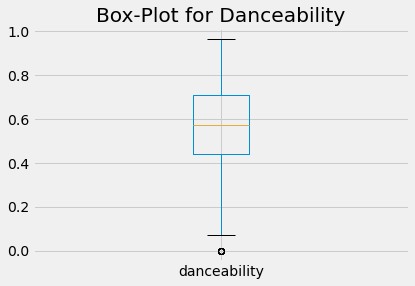

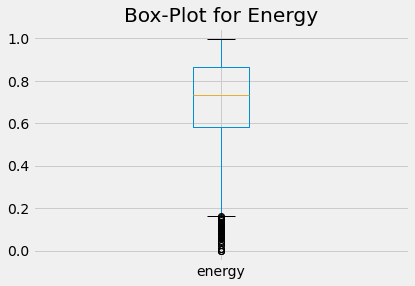

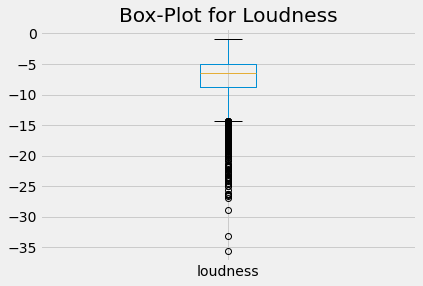

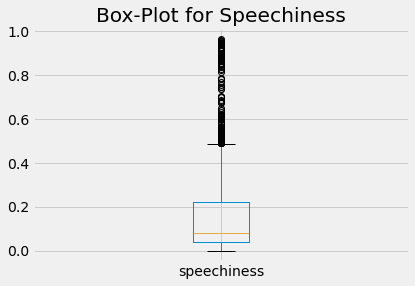

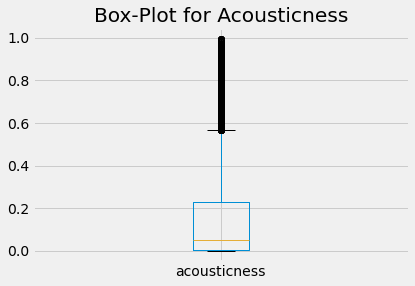

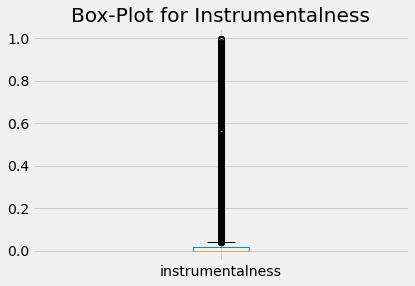

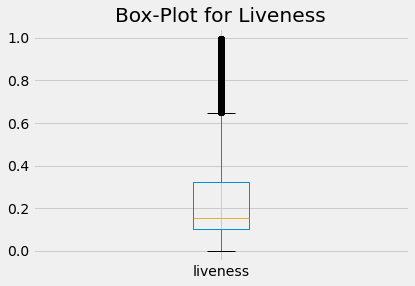

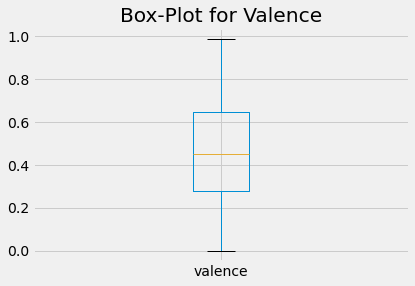

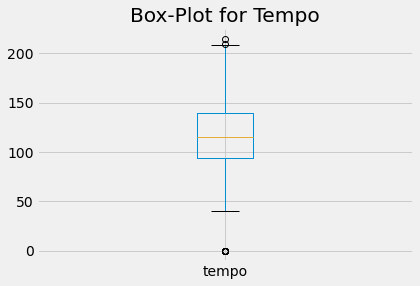

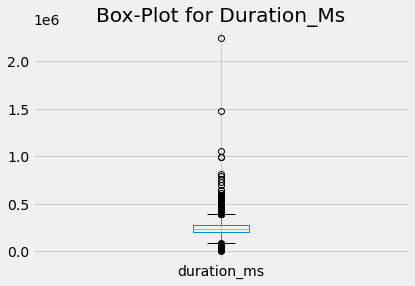

In [24]:
for each in plot_list:
    plot_box_plots(all_songs, each)

In [25]:
all_songs.query("danceability == 0")

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,genre
688,0.0,0.2160,6,-17.465,1,0.0,0.570,0.000000,0.143,0.0,0.0,0gf3RV9uNeiXgII9bBj3uU,11187.0,0,hip-hop
1715,0.0,0.4730,1,-16.139,1,0.0,0.485,0.000004,0.683,0.0,0.0,4ymIihKTFmk3s0wrgud1kU,81800.0,0,alt-metal
1826,0.0,0.1730,6,-18.560,1,0.0,0.385,0.000004,0.000,0.0,0.0,3DO3XiJr2RQqDjeTUkThI9,7173.0,0,hip-hop
2198,0.0,0.0613,9,-22.937,1,0.0,0.318,0.000000,0.317,0.0,0.0,7rNv06qGP8OwY49hw06V0p,13853.0,0,rock
3170,0.0,0.3030,4,-22.355,1,0.0,0.970,0.000000,0.617,0.0,0.0,49cwtNGrl6Zr28VnoeJp9P,13400.0,0,hip-hop
3349,0.0,0.2530,0,-16.671,1,0.0,0.603,0.000000,0.126,0.0,0.0,1HNNuNdS3TGXayZ85NujZ7,8120.0,0,hip-hop
4967,0.0,0.3030,4,-22.355,1,0.0,0.970,0.000000,0.617,0.0,0.0,3izxuGg0shtMWtx34YeIAl,13400.0,0,hip-hop
5231,0.0,0.1160,0,-26.914,1,0.0,0.989,0.000000,0.248,0.0,0.0,1CSGZRbxGVY4zXbEEZcHsP,8293.0,0,alt-metal


In [26]:
all_songs = all_songs.query("danceability != 0")

In [27]:
all_songs.query("tempo == 0")

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,genre


In [28]:
all_songs.query(f"duration_ms > {1e6}")

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,genre
1667,0.484,0.00002,9,-7.882,1,0.5640,0.027300,0.000445,0.101,0.1660,154.940,3xDqp17OhojUpBtexY9Ag6,1472840.0,4,hip-hop
2715,0.251,0.40100,7,-10.757,0,0.0307,0.641000,0.746000,0.127,0.0549,136.032,0nf3lHp1oIkCCpmFpBxi7y,1052453.0,3,rock
4231,0.246,0.00002,10,-5.607,0,0.1130,0.000037,0.075600,0.315,0.1090,85.663,0CSZ1DMvRZH0WLB5V0WSom,2238734.0,4,alt-metal


In [29]:
all_songs = all_songs.query(f"duration_ms < {1e6}")

Mostly all features have no outliers. Either they are within the minimum and maximum or they are grouped with many songs outside of the minimum maximum range.


Songs that have a danceability of 0 also have a tempo of 0. After further research, I came to the realization that they are either spoken word or skits so those will be removed.

Lastly, remove the crazy outliers in duration_ms which are songs that are just extremely long. 

In [30]:
all_songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,genre
0,0.253,0.888,4,-4.592,0,0.0787,0.000225,0.013200,0.9960,0.195,105.763,3AfajMb3XqqpE97TudO1ab,373800.0,4,alt-metal
1,0.846,0.416,10,-13.767,0,0.1180,0.156000,0.000009,0.2380,0.645,96.188,4voEoczU7Ijborps9XF1n3,259000.0,4,hip-hop
2,0.381,0.162,5,-12.440,1,0.0295,0.880000,0.000000,0.0882,0.345,96.744,3iD2CCv5bsJRIaqJRYD0uJ,125533.0,4,rock
3,0.521,0.881,10,-5.417,0,0.0850,0.000922,0.035100,0.0976,0.377,150.151,7rRLVR3QZOGPkNckz4DSAc,250107.0,3,alt-metal
4,0.844,0.809,2,-7.320,1,0.0476,0.002020,0.759000,0.0984,0.753,108.343,23SDAWj9QEg7KEB77MMFPf,212467.0,4,hip-hop


In [31]:
all_songs['mode'].value_counts()

1    3214
0    2043
Name: mode, dtype: int64

In [32]:
# Function to plot barplot grouped by mean
def plotbar_groupby_genre(groupby, genre, feature, ax, ticklabel = None, orient='h'):

    if (orient=='h'):
            if(ticklabel is None):
                ax.barh(groupby.index.sort_values(ascending=False),
                       groupby.values)
            else:
                   ax.barh(groupby.index.sort_values(ascending=False),
                   groupby.values,
                   tick_label = ticklabel)
    else:
            if(ticklabel is None):
                ax.bar(groupby.index.sort_values(ascending=False),
                       groupby.values)
            else:
                ax.bar(groupby.index.sort_values(ascending=False),
                groupby.values,
                tick_label = ticklabel)
    ax.set_title(f'# Songs in {feature} within {genre} ', fontdict = {'fontsize' : 15})
    ax.set_ylabel('Count', fontdict = {'fontsize' : 12})

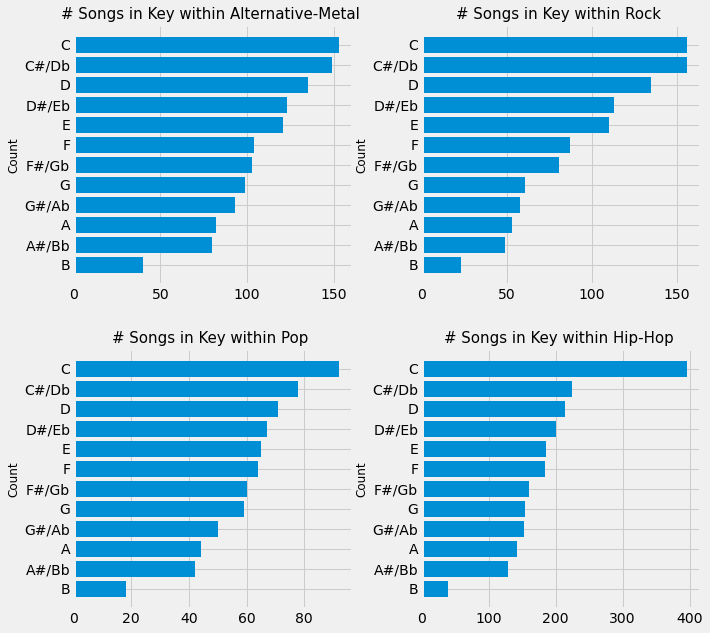

In [33]:
fig, axes = plt.subplots(2,2, figsize = (10,10))
fig.subplots_adjust(hspace=.25, wspace = .25)
am_group_key = all_songs.groupby('genre').key.value_counts()['alt-metal']
vc_keys_hh = all_songs.groupby('genre').key.value_counts()['hip-hop']
vc_keys_pop = all_songs.groupby('genre').key.value_counts()['pop']
vc_keys_rock = all_songs.groupby('genre').key.value_counts()['rock']

#plot key by genre
plotbar_groupby_genre(am_group_key, 'Alternative-Metal', 'Key', 
                   axes[0,0], ticklabel = key_octave_values)
plotbar_groupby_genre(vc_keys_rock, 'Rock','Key',
                   axes[0,1],  ticklabel = key_octave_values)
plotbar_groupby_genre(vc_keys_pop, 'Pop','Key', 
                   axes[1,0], ticklabel = key_octave_values)
plotbar_groupby_genre(vc_keys_hh, 'Hip-Hop', 'Key',
                   axes[1,1], ticklabel = key_octave_values)

plt.show()

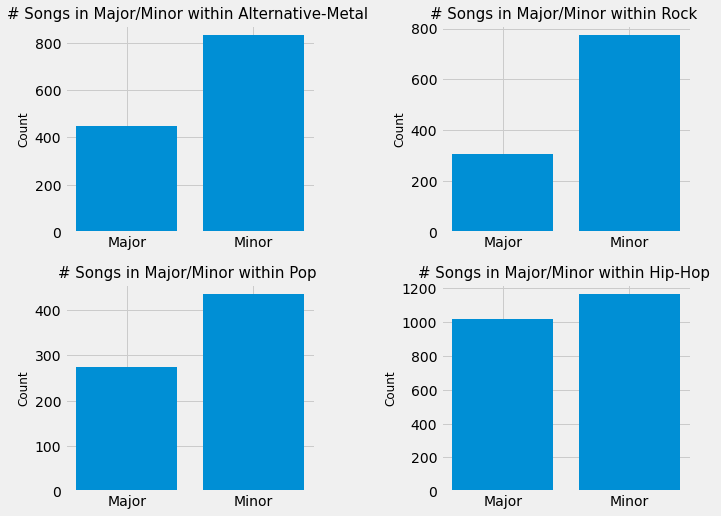

In [34]:
fig, axes = plt.subplots(2,2, figsize = (10,8))
fig.subplots_adjust(hspace=.25, wspace = .50)
vc_mode_am = all_songs.groupby('genre')['mode'].value_counts()['alt-metal']
vc_mode_rock = all_songs.groupby('genre')['mode'].value_counts()['rock']
vc_mode_pop = all_songs.groupby('genre')['mode'].value_counts()['pop']
vc_mode_hh = all_songs.groupby('genre')['mode'].value_counts()['hip-hop']


#plot key by mode
plotbar_groupby_genre(vc_mode_am, 'Alternative-Metal', 'Major/Minor', 
                   axes[0,0], ticklabel = mode_mm_values, orient='v')
plotbar_groupby_genre(vc_mode_rock, 'Rock','Major/Minor',
                   axes[0,1],  ticklabel = mode_mm_values, orient='v')
plotbar_groupby_genre(vc_mode_pop, 'Pop','Major/Minor', 
                   axes[1,0], ticklabel = mode_mm_values, orient='v')
plotbar_groupby_genre(vc_mode_hh, 'Hip-Hop', 'Major/Minor',
                   axes[1,1], ticklabel = mode_mm_values, orient='v')

In [35]:
def mean_by_genre_plot(groupby, feature):
    fig, ax = plt.subplots()
    sns.barplot(x = all_songs.groupby('genre')[feature].mean().index,
                y = all_songs.groupby('genre')[feature].mean().values,
                ax = ax,)
    ax.set_title(f'Average {feature.title()} by Genre')
    ax.set_ylabel(f'{feature}');
    plt.xticks(rotation=90)

    plt.show()

In [36]:
genre_group = all_songs.groupby('genre')

In [37]:
continuous_features = list(all_songs.select_dtypes(include = [float, int]).columns)

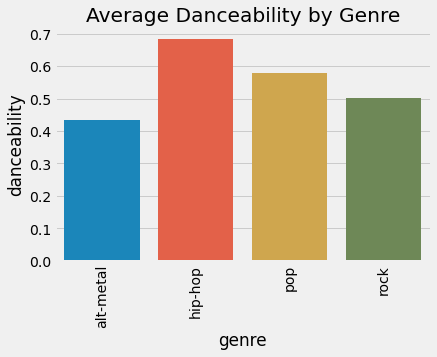

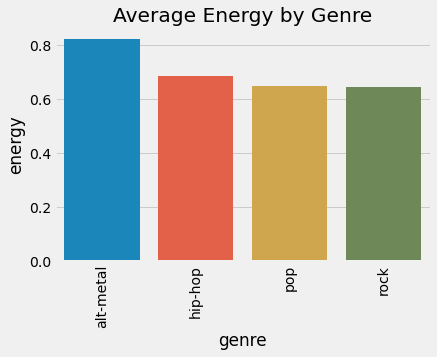

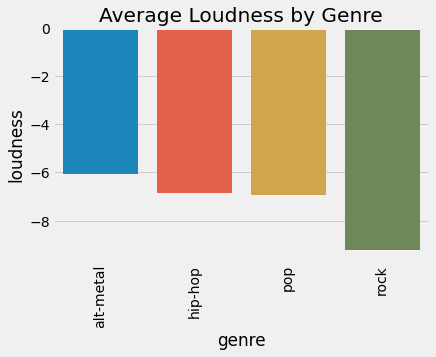

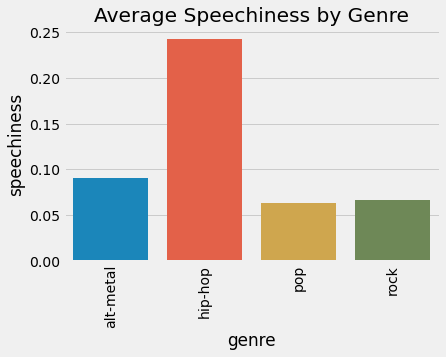

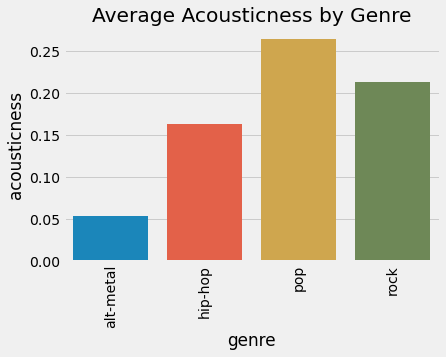

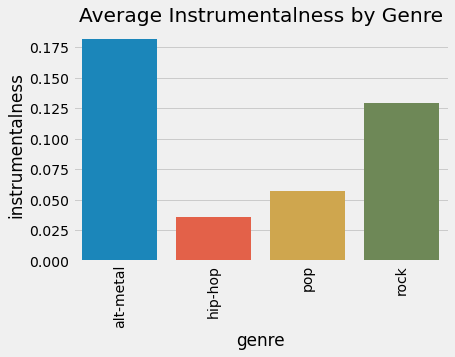

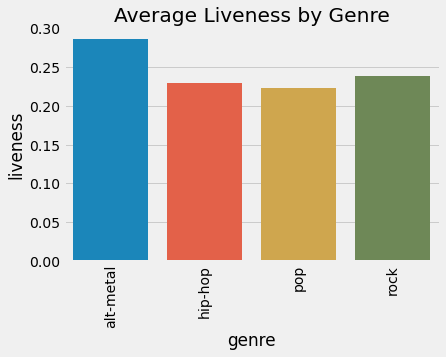

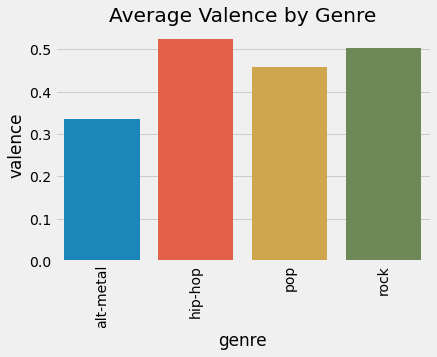

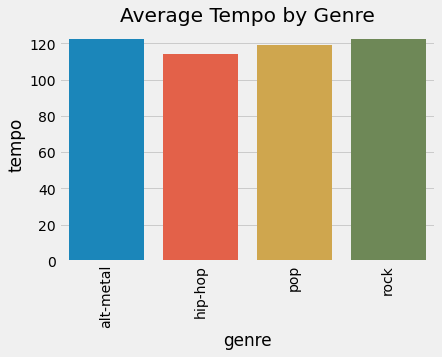

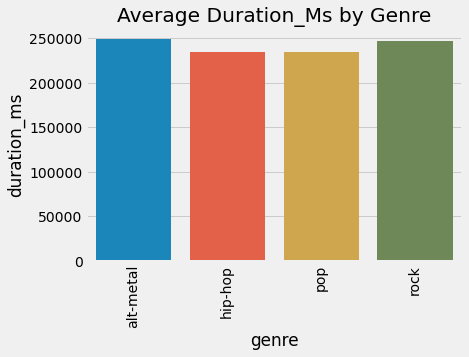

In [38]:
#plot the continous features by genre
for each in continuous_features:
    mean_by_genre_plot(genre_group, each)

Danceability - Hip-hop and pop seem to be the more danceable songs to no surprise. 

Loudness - Surprised alt-metal being the quietest and rock being high is interesting. I expect the model to be confused by these two genres so I wonder what’ll happen. 

Speechiness - On par that its hip-hop

Instrumentalness - On par that it is alt-metal and rock being the highest of the four

Valence - Quite surprised that hip-hop would have the highest valence, would’ve guessed pop music

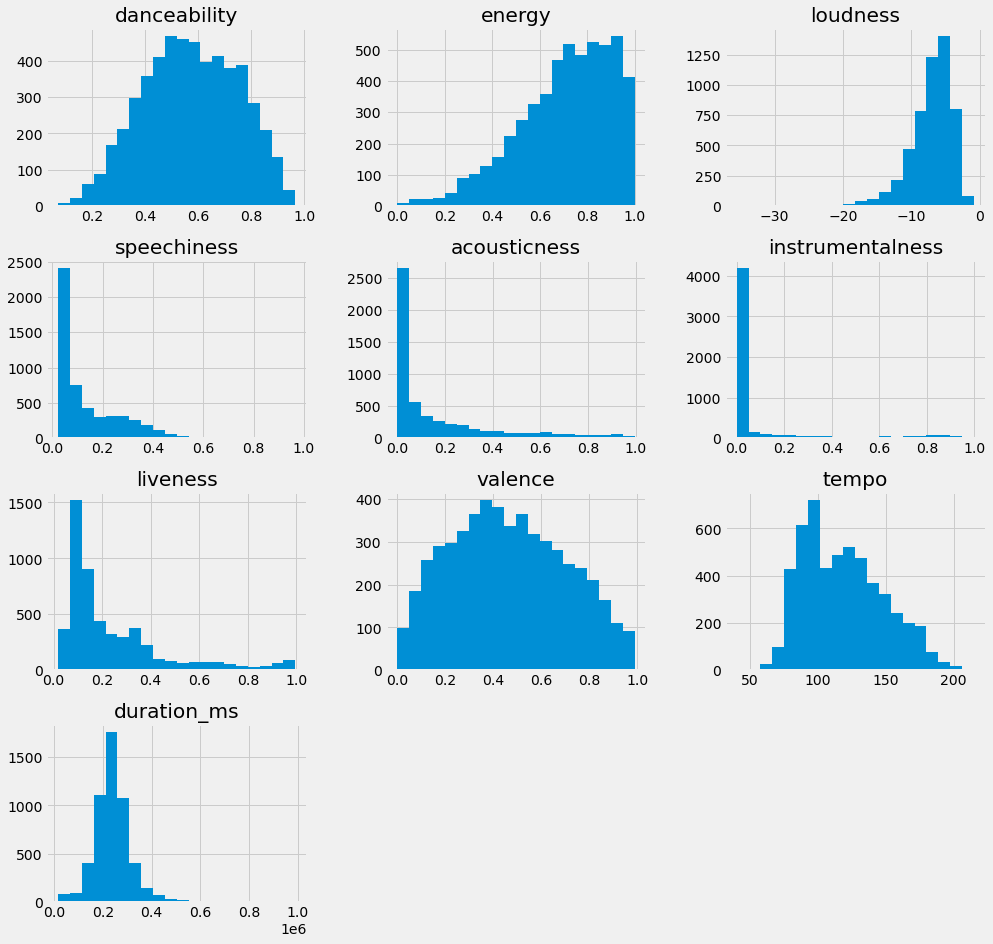

In [39]:
# view distribution of the continuous features and double check for outliers
all_songs.hist(bins=20, figsize=(15,15));

In [40]:
# Remove songs that are 5 standard deviations from the mean
all_songs = all_songs[(np.abs(stats.zscore(all_songs[all_songs.select_dtypes(exclude='object').columns])) < 5).all(axis=1)]

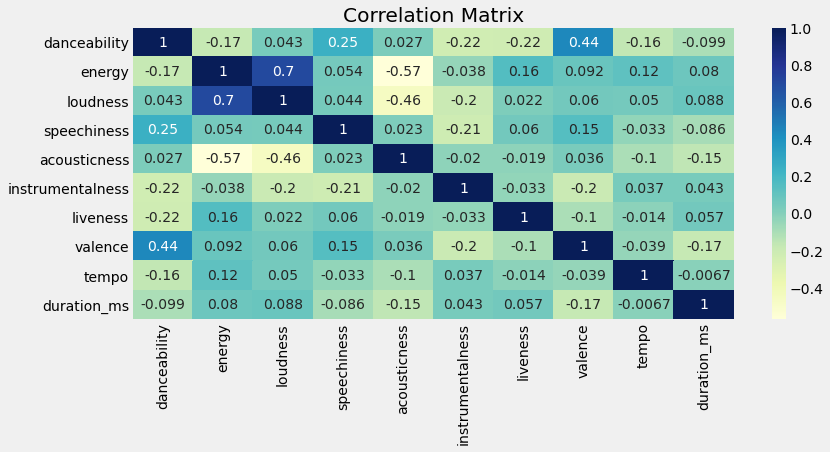

In [41]:
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(all_songs.corr(), annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show()

Correlation matrix shows that there aren't continuous features that seem to be significantly collinear (score > .75) with one another so good to go. 

In [42]:
all_songs

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,genre
0,0.253,0.888,4,-4.592,0,0.0787,0.000225,0.013200,0.9960,0.195,105.763,3AfajMb3XqqpE97TudO1ab,373800.0,4,alt-metal
1,0.846,0.416,10,-13.767,0,0.1180,0.156000,0.000009,0.2380,0.645,96.188,4voEoczU7Ijborps9XF1n3,259000.0,4,hip-hop
2,0.381,0.162,5,-12.440,1,0.0295,0.880000,0.000000,0.0882,0.345,96.744,3iD2CCv5bsJRIaqJRYD0uJ,125533.0,4,rock
3,0.521,0.881,10,-5.417,0,0.0850,0.000922,0.035100,0.0976,0.377,150.151,7rRLVR3QZOGPkNckz4DSAc,250107.0,3,alt-metal
4,0.844,0.809,2,-7.320,1,0.0476,0.002020,0.759000,0.0984,0.753,108.343,23SDAWj9QEg7KEB77MMFPf,212467.0,4,hip-hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5263,0.453,0.947,0,-5.292,1,0.0731,0.000214,0.000464,0.4900,0.265,117.963,1hSXWecpKNqhAkxZ5FMBe9,172307.0,4,alt-metal
5264,0.556,0.849,9,-6.465,0,0.0417,0.004530,0.000016,0.2720,0.290,105.016,6LtfQ7JJkkDw2t9hxJOwnf,236093.0,4,hip-hop
5265,0.561,0.774,1,-3.144,0,0.4470,0.399000,0.000002,0.1890,0.820,77.621,0eK5y1c7WDyWwx6k9SFjbT,337760.0,1,hip-hop
5266,0.507,0.803,5,-5.314,0,0.2140,0.287000,0.000000,0.2670,0.647,86.295,1g1zk6gOFE63kDszT1luxY,182387.0,4,hip-hop


In [43]:
import pickle

In [44]:
#Export the model to be used in the other notebooks.
pickle_out = open('pickled_files/df.pickle',"wb")
pickle.dump(all_songs, pickle_out)
pickle_out.close()